# 2. CNN for Sentence Classification (Kim 2014)
- This is Keras implementation for **CNN for Sentence Classification** paper (Kim, Y. (2014). Convolutional neural networks for sentence classification. arXiv preprint arXiv:1408.5882.) 
- There are four model variations
    - ```CNN-rand```: "Our baseline model where all words are randomly initialized and then modified during training."
    - ```CNN-static```: "A model with pre-trained vectors from word2vec. All words-including the unknown ones that are randomly initialized—are kept static and only the other parameters of the model are learned."
    - ```CNN-non-static```: "Same as above but the pretrained vectors are fine-tuned for each task."
    - ```CNN-multichannel```: "A model with two sets of word vectors. Each set of vectors is treated as a ‘channel’ and each filter is applied to both channels, but gradients are backpropagated only through one of the channels. Hence the model is able to fine-tune one set of vectors while keeping the other static. Both channels are initialized with word2vec."
    
</br>
<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM.png" style="width: 800px"/>
    
- Dataset used is **Sentiment Analysis on Movie Reviews** from Kaggle
    - source: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from keras.layers import *
from keras.models import *
from keras.utils import to_categorical
from keras.callbacks import *
from keras import optimizers

## Dataset import and preprocessing

In [2]:
# exclude partial phrases, and import only sentences
df = pd.read_csv("data\train.tsv", delimiter = '\t').groupby(['SentenceId']).head(1)[['Phrase', 'Sentiment']]
df = df.reset_index(drop = True)
print(df.shape)
print(df.head())

(8529, 2)
                                              Phrase  Sentiment
0  A series of escapades demonstrating the adage ...          1
1  This quiet , introspective and entertaining in...          4
2  Even fans of Ismail Merchant 's work , I suspe...          1
3  A positively thrilling combination of ethnogra...          3
4  Aggressive self-glorification and a manipulati...          1


In [3]:
num_tokens = 10000      # number of tokens
embed_dim = 50          # set word2vec embedding dim = 50

In [8]:
tokenizer = Tokenizer(num_words = num_tokens)
tokenizer.fit_on_texts(df['Phrase'])
sentences = tokenizer.texts_to_sequences(df['Phrase'])
word_idx = tokenizer.word_index

In [9]:
for i in range(len(sentences)):
    for j in range(len(sentences[i])):
        sentences[i][j] = str(sentences[i][j])

In [11]:
# generate word2vec model with encoded sentences
model = Word2Vec(sentences = sentences, size = embed_dim, sg = 1, window = 3, min_count = 1, iter = 10, workers = Pool()._processes)  
model.init_sims(replace = True)

In [13]:
sentences = pad_sequences(sentences, maxlen = len(max(sentences, key = len)), padding = 'post')

In [33]:
embedding_matrix = np.zeros((len(word_idx) + 1, embed_dim))

for word, idx in word_idx.items():
    try:
        embedding_matrix[idx] = model[str(idx)]
    except:
        pass

print(len(word_idx))
print(embedding_matrix.shape)

15213
(15214, 50)


In [35]:
# split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, df['Sentiment'])
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6396, 47) (2133, 47) (6396, 5) (2133, 5)


### CNN-rand
- All words are randomly initialized and the modified during training

In [44]:
def cnn_rand(embed_dim, num_tokens, max_len, windows = [3, 4, 5], filters = 100, p = 0.5, l2 = 3):
    inputs = Input(shape = (max_len, ))
    embedded = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                         input_length = max_len, trainable = True)(inputs)
    conv_results = []
    for window in windows:
        x = Conv1D(filters, window, activation = 'relu')(embedded)
        x = Dropout(p)(x)
        x = MaxPooling1D(max_len - window + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(50)(x)
    outputs = Dense(5, activation = 'softmax')(x)
    m = Model(inputs = inputs, outputs = outputs)
    m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return m

In [40]:
cnn_rand = cnn_rand(embed_dim, num_tokens, X_train.shape[1])
callbacks = [ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only = True, mode='max')]

In [ ]:
history = cnn_rand.fit(X_train, y_train, epochs = 100, callbacks = callbacks, validation_split = 0.1, batch_size = 50)

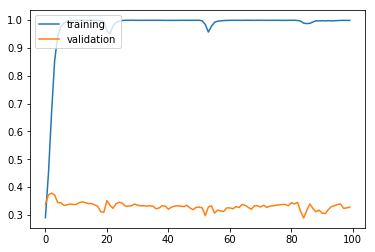

In [42]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [46]:
cnn_rand_best_model = cnn_rand(embed_dim=embed_dim , num_tokens=num_tokens, max_len=X_train.shape[1])
cnn_rand_best_model.load_weights('best_model.hdf5')
cnn_rand_best_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
results = cnn_rand_best_model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

2133/2133 [==============================] - 0s     
Test accuracy:  0.390060947037


## CNN-static
- A model with pre-trained vectors from ```word2vec```. All words - including the unknown ones that are randomly initialized- are kept static and only the other parameters of the model are learned

In [52]:
def cnn_static(embed_dim, num_tokens, max_len, windows = [3, 4, 5], filters = 100, p = 0.5, l2 = 3):
    inputs = Input(shape = (max_len, ))
    embedd_intializer = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                         input_length = max_len, weights = [embedding_matrix], trainable = False)
    embedded = embedd_intializer(inputs)

    
    conv_results = []
    for window in windows:
        x = Conv1D(filters, window, activation = 'relu')(embedded)
        x = Dropout(p)(x)
        x = MaxPooling1D(max_len - window + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(50)(x)
    outputs = Dense(5, activation = 'softmax')(x)
    m = Model(inputs = inputs, outputs = outputs)
    m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return m

In [49]:
cnn_static = cnn_static(embed_dim, num_tokens, X_train.shape[1])
callbacks = [ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only = True, mode='max')]

In [ ]:
history = cnn_static.fit(X_train, y_train, epochs = 100, callbacks = callbacks, validation_split = 0.1, batch_size = 50)

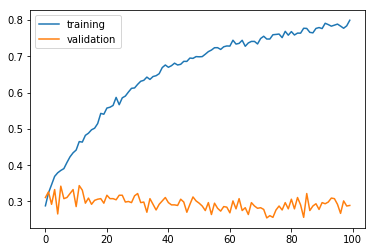

In [51]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [54]:
cnn_static_best_model = cnn_static(embed_dim=embed_dim , num_tokens=num_tokens, max_len=X_train.shape[1])
cnn_static_best_model.load_weights('best_model.hdf5')
cnn_static_best_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
results = cnn_static_best_model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

1792/2133 [========================>.....] - ETA: 0sTest accuracy:  0.341303328715


## CNN-non-static
- Same as above, but the pretrained vectors are fine-tuned for each task

In [61]:
def cnn_non_static(embed_dim, num_tokens, max_len, windows = [3, 4, 5], filters = 100, p = 0.5, l2 = 3):
    inputs = Input(shape = (max_len, ))
    embedd_intializer = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                     input_length = max_len, weights = [embedding_matrix], trainable = True)
    embedded = embedd_intializer(inputs)
    
    conv_results = []
    for window in windows:
        x = Conv1D(filters, window, activation = 'relu')(embedded)
        x = Dropout(p)(x)
        x = MaxPooling1D(max_len - window + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(50)(x)
    outputs = Dense(5, activation = 'softmax')(x)
    m = Model(inputs = inputs, outputs = outputs)
    m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return m

In [58]:
cnn_non_static = cnn_non_static(embed_dim, num_tokens, X_train.shape[1])
callbacks = [ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only = True, mode='max')]

In [ ]:
history = cnn_non_static.fit(X_train, y_train, epochs = 100, callbacks = callbacks, validation_split = 0.1, batch_size = 50)

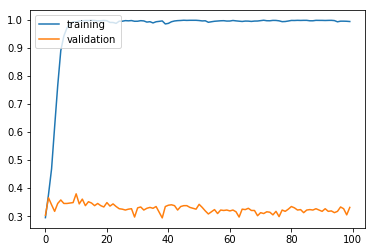

In [60]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [62]:
cnn_non_static_best_model = cnn_non_static(embed_dim=embed_dim , num_tokens=num_tokens, max_len=X_train.shape[1])
cnn_non_static_best_model.load_weights('best_model.hdf5')
cnn_non_static_best_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
results = cnn_non_static_best_model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

2016/2133 [===========================>..] - ETA: 0sTest accuracy:  0.389592124049


## CNN-multichannel
- A model with two sets of word vectors

In [67]:
def cnn_multichannel(embed_dim, num_tokens, max_len, windows = [3, 4, 5], filters = 100, p = 0.5, l2 = 3):
    inputs = Input(shape = (max_len, ))
    embedd_intializer = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                     input_length = max_len, weights = [embedding_matrix], trainable = True)
    embedded_1 = embedd_intializer(inputs)
    
    embedd_intializer = Embedding(input_dim = len(word_idx) + 1, output_dim = embed_dim, \
                     input_length = max_len, weights = [embedding_matrix], trainable = False)
    embedded_2 = embedd_intializer(inputs)
    
    embedded = concatenate([embedded_1, embedded_2])
    
    conv_results = []
    for window in windows:
        x = Conv1D(filters, window, activation = 'relu')(embedded)
        x = Dropout(p)(x)
        x = MaxPooling1D(max_len - window + 1)(x)
        conv_results.append(x)
    conv_result = concatenate(conv_results)
    x = GlobalMaxPooling1D()(conv_result)
    x = Dense(50)(x)
    outputs = Dense(5, activation = 'softmax')(x)
    m = Model(inputs = inputs, outputs = outputs)
    m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return m

In [64]:
cnn_multichannel = cnn_multichannel(embed_dim, num_tokens, X_train.shape[1])
callbacks = [ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only = True, mode='max')]

In [ ]:
history = cnn_multichannel.fit(X_train, y_train, epochs = 100, callbacks = callbacks, validation_split = 0.1, batch_size = 50)

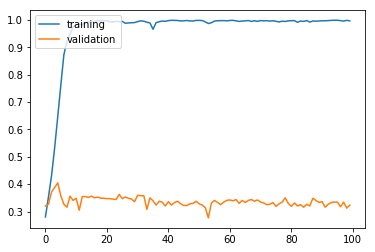

In [66]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [68]:
cnn_multichannel_best_model = cnn_multichannel(embed_dim=embed_dim , num_tokens=num_tokens, max_len=X_train.shape[1])
cnn_multichannel_best_model.load_weights('best_model.hdf5')
cnn_multichannel_best_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
results = cnn_multichannel_best_model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

2133/2133 [==============================] - 0s     
Test accuracy:  0.407407407687


## Results
- All four model variations show high level of training accuracy (almost 1.0), but suffer from low level of validation/test accuracy (below 0.4)
- Test accuracies
    - ```CNN-rand```: 0.390060947037
    - ```CNN-static```: 0.341303328715
    - ```CNN-non-static```: 0.389592124049
    - ```CNN-multichannel```: 0.407407407687
- So with this dataset, ```CNN-multichannel``` model performs best